# Read in the data

In [31]:
import pandas as pd

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for f in data_files:
    d = pd.read_csv("schools/{}".format(f))  # put in file name in "{}"
    key_name = f.replace(".csv", "")
    data[key_name] = d

# Read in the survey data

In [32]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)
survey["DBN"] = survey["dbn"]
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]  # only include the interesting columns
data["survey"] = survey

# Add DBN for class_size.csv

In [33]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(csd):
    string_csd = str(csd)
    length = len(string_csd)
    if length == 1:
        return string_csd.zfill(2)
    else:
        return string_csd
        
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Sum up SAT scores into one

In [34]:
data["sat_results"]["SAT Math Avg. Score"] = pd.to_numeric(data["sat_results"]["SAT Math Avg. Score"], errors="coerce")
data["sat_results"]["SAT Critical Reading Avg. Score"] = pd.to_numeric(data["sat_results"]["SAT Critical Reading Avg. Score"], errors="coerce")
data["sat_results"]["SAT Writing Avg. Score"] = pd.to_numeric(data["sat_results"]["SAT Writing Avg. Score"], errors="coerce")
data["sat_results"]["sat_score"] = data["sat_results"]["SAT Math Avg. Score"] + data["sat_results"]["SAT Critical Reading Avg. Score"] + data["sat_results"]["SAT Writing Avg. Score"]

# Store coordinates for each high school

In [35]:
import re

def extract_lat(location):
    coords = re.findall("\(.+, .+\)", location)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def extract_lon(location):
    coords = re.findall("\(.+, .+\)", location)
    lon = coords[0].split(",")[1].replace(")", "")
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(extract_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(extract_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Make DBN unique in class_size, graduation, and demographics

In [36]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

import numpy

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

In [37]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

In [38]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores into numeric

In [39]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Join the datasets

In [40]:
# the goal is to keep as many rows from "sat_results" as possible without creating a lot of rows with missing values.
# "ap_2010" and "graduation" have many missing values, so we use left join.
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# these datasets don't have many missing values, so we use inner join.
combined = combined.merge(data["class_size"], on="DBN", how="inner")
combined = combined.merge(data["demographics"], on="DBN", how="inner")
combined = combined.merge(data["survey"], on="DBN", how="inner")
combined = combined.merge(data["hs_directory"], on="DBN", how="inner")

# Fill in missing values with average and then with 0

In [41]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [42]:
def extract_two_chars(string):
    return string[0:2]

combined["school_dist"] = combined["DBN"].apply(extract_two_chars)

# Find correlations

In [43]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Total enrollment vs. SAT scores

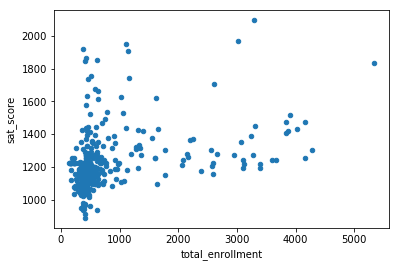

In [44]:
import matplotlib.pyplot as plt

combined.plot.scatter(x="total_enrollment", y="sat_score")
plt.show()

The r-score of 0.367857 suggested that there might be a positive correlation between "sat_score" and "total_enrollment." However, the scatter plot does not show any clear line of points and therefore shows that there is not a strong correlation between the two variables. 

There is a big cluster of points for the low enrollment and low sat score schools.

In [45]:
low_enrollment = combined[combined["total_enrollment"] < 1000]
low_enrollment = low_enrollment[low_enrollment["sat_score"] < 1000]
print(low_enrollment["School Name"])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


Most high schools that had "total_enrollment" of less than 1000 and "sat_score" of lower than 1000 were international schools. Perhaps, schools with higher percentage of English learners have lower sat score.

# ELL percent vs. SAT scores

ELL means English language learner.

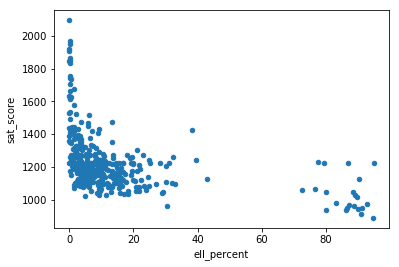

In [46]:
combined.plot.scatter(x="ell_percent", y="sat_score")
plt.show()

The r-score between "ell_percent" and "sat_score" was -0.398750. But again, the scatterplot shows that there is not a strong correlation between "ell_percent" and "sat_score."

//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


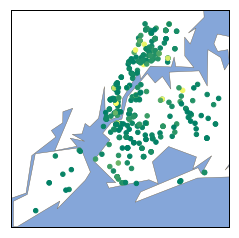

In [47]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")
plt.show()

# Group by school districts

In [48]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


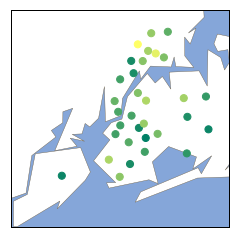

In [49]:
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")
plt.show()

# Surveys vs. SAT scores

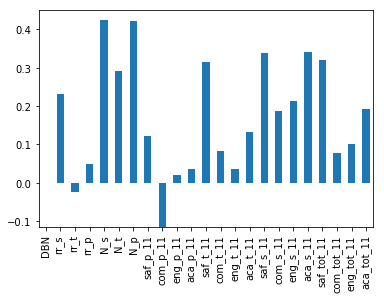

In [50]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

- For response rates ("rr_"), students' response rate is somewhat correlated to "sat_score" (~0.23), and teachers' and parents' are not correlated.
- For number of respondents ("N_"), students', teachers', and parents' are all correlated (~0.3-0.4).
- For safety and respect scores ("saf_"), students' and teachers' were correlated (~0.3), but parents' was not quite (~0.12).
- For academic expectations scores ("aca_"), students' was correlated (~0.3), teachers' a little bit, and parent's not at all.
- For communication scores ("com_"), only students' was somewhat correlated (~0.2).
- For engagement scores ("eng_"), only students' was somewhat correlated (~0.2).

How students responded to the surveys and their SAT scores seem to be the most correlated.

# Safety vs. SAT scores

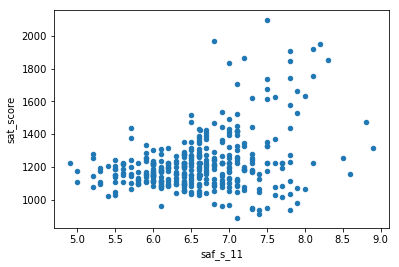

In [51]:
combined.plot.scatter(x="saf_s_11", y="sat_score")

There is a slight positive correlation. There are a few schools with high safety scores and high SAT scores, and there are a few schools with low safety scores and low SAT scores. When the students' safety scores are lower than about 6.4, the SAT scores do not go over 1600.

# Plot safety score by district on a map

//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
//anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


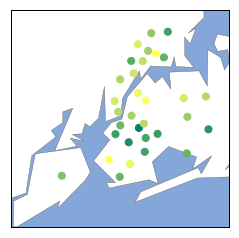

In [53]:
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")

<img align="left" src="nyc_borroughs.png" width=235px height=235px>

photo source: http://www.nycgo.com/boroughs-neighborhoods

Yellower points indicate higher safety scores, and greener points indicate lower saftey scores.

Schools in Manhattan, inbetween Queens and Brooklyn, and southwestern region of Brooklyn have higher safety scores according to the students.

# Race vs. SAT scores

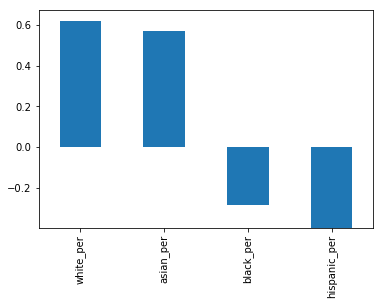

In [58]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

Percentages of white students and Asian students have positive correlations, and percentages of black students and Hispanic students have slight negative correlations.

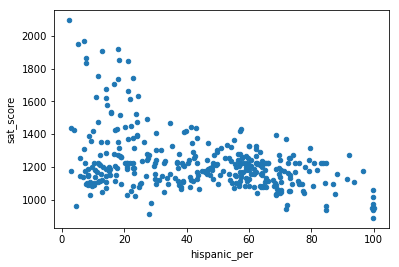

In [59]:
combined.plot.scatter(x="hispanic_per", y="sat_score")

There is a negative correlation. There are chunks of schools with around 15% and with around 60% Hispanic students that have SAT scores lower than 1400.

In [61]:
hispanic_95 = combined[combined["hispanic_per"] > 95]
print(hispanic_95["school_name"])

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object


The schools found above seem to be international schools that probably have many students who are still learning English. That might explain the lower SAT scores.

In [64]:
hispanic_10 = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]
print(hispanic_10["school_name"])

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object


These schools are technical and science high schools. Perhaps, students need to take exams to get into these schools.

# Gender vs. SAT scores

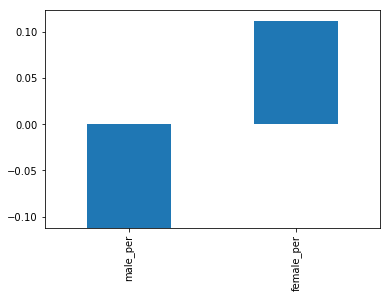

In [65]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

Female percentage has a slight positive correlation, and male percentage has a slight negative correlation.

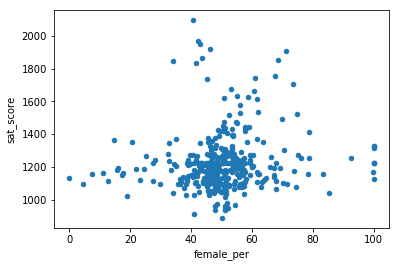

In [66]:
combined.plot.scatter(x="female_per", y="sat_score")

There is not a clear correlation. There are some schools with high SAT scores with female percentage between 40% and 60%.

In [68]:
print(combined[(combined["female_per"] < 60) & (combined["sat_score"] > 1700)]["school_name"])

37                                Stuyvesant High School
79     High School for Mathematics, Science and Engin...
151                         Bronx High School of Science
155    High School of American Studies at Lehman College
187                       Brooklyn Technical High School
198                           Brooklyn Latin School, The
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object


Similar to when we looked at the schools with low Hispanic student percentage and high SAT score, the schools listed above are technical/math/science schools.

# AP scores vs. SAT scores

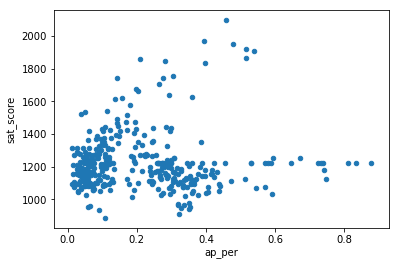

In [69]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x="ap_per", y="sat_score")

There is not a strong correlation.

The scatterplot shows two slight trends: 
- one where SAT scores increase as percentages of students who have taken at least one AP test increases, and
- another where SAT scores stay around 1200 even as "ap_per" increases.